In [1]:
import pandas as pd
import numpy as np

import time
import sys
from tqdm.notebook import tqdm
import gc


import torch
pd.set_option('display.max_colwidth', -1)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler # pour centrer et normer (variance 1)

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [2]:
path_data = "/Users/yohannlefaou/Documents/data/posos/"

In [3]:
train = pd.read_csv(path_data +"input_train.csv", sep=",")


In [4]:
labels = pd.read_csv(path_data + "output_train.csv", sep=",")

In [5]:
train.head()

,ID,question
0,0,"bonjour, je m suis trompé de forum pour ma question alors je la repose ici. je pris pour la première fois hier du paroxétine et ce matin c'est une catastrophe. picotement dasn tous le corps annonciateur de sueur froide très très massive et de vomissement. j'en suis à deux crises depuis 5 heure du mat. la cela semble passer mes mes mains reste moites et chaude estce normal pour la première fois merci a tous"
1,1,est ce que le motilium me soulagera contre les nausées?
2,2,"mon médecin m'a prescrit adenyl. au 2ème cachet des maux de tête terribles et au 3ème palpitations, sueurs froides, chaleur intense dans la tête, tremblements, fourmillements dans la lèvre supérieure, difficultés à respirer.. dès l'arrêt du médicament tous les symptômes ont disparu. cela est-il déjà arrivé à quelqu'un??"
3,3,Est-ce qu'il existe une forme adaptée aux enfant de 5ans du Micropakine ?
4,4,mon medecin me soigne pour une rhino pharingite et m'a prescrit du amoxicilline comme anti biotique. Est-ce vraiment pour cette indication?


In [6]:
labels.head()

,ID,intention
0,0,28
1,1,31
2,2,28
3,3,44
4,4,31


In [7]:
camembert = torch.hub.load('pytorch/fairseq', 'camembert.v0')

Using cache found in /Users/yohannlefaou/.cache/torch/hub/pytorch_fairseq_master


loading archive file http://dl.fbaipublicfiles.com/fairseq/models/camembert.v0.tar.gz from cache at /Users/yohannlefaou/.cache/torch/pytorch_fairseq/df8ea5d155cb66cfb63da3aea2b4e72963253193e2355dc97c94e3442753b1ee.d1e3eb8a6a216f388fe37b689e1278c67aa17f914c446561739f1b0aa88addf2
| dictionary: 32004 types


In [9]:
line = train["question"][0]
print(line)
tokens = camembert.encode(line)
print(len(tokens))
print(tokens)
last_layer_features = camembert.extract_features(tokens)
print(last_layer_features)

bonjour,  je m suis trompé de forum pour ma question alors je la repose ici. je pris pour la première fois hier du paroxétine et ce matin c'est une catastrophe. picotement dasn tous le corps annonciateur de sueur froide très très massive et de vomissement. j'en suis à deux crises depuis 5 heure du mat. la cela semble passer mes mes mains reste moites et chaude estce normal pour la première fois merci a tous
99
tensor([    5,  5061,     7,    50,   115,   146, 12125,     8,  1026,    24,
          155,   397,   183,    50,    13,  4537,   323,     9,    50,   523,
           24,    13,   272,   151,  2067,    25,    37,  5321,   141,  4030,
           14,    44,   823,    60,    11,    41,    28,  7978,     9,  5461,
         4613,   131,    18,   636,   255,   117,    16,   486,    21, 13758,
          244,  1569,     8, 18416,  4185,    95,    95,  9750,    14,     8,
        17381,  5872,     9,    76,    11,    90,   146,    15,   116, 10788,
          176,   205,  1507,    25,  603

In [10]:
# rmq : on a un embedding de taille 768 pour chaque token
print(last_layer_features.size())

torch.Size([1, 99, 768])


# Mean embeddings

In [11]:
# on  fait la moyenne des embeedings de tous les tokens
max_tokens = 512 # maximum number of tokens in order to compute embeddings
sentence_tokens = []
sentence_embeddings = []
for i in tqdm(range(len(train))):
    line = train["question"][i]
    tokens = camembert.encode(line)
    sentence_tokens.append(tokens)
    last_layer_features = camembert.extract_features(tokens[:max_tokens])
    sentence_embeddings.append(torch.mean(last_layer_features, dim=1).squeeze().tolist())

[]

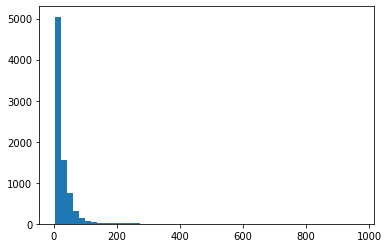

In [13]:
# histo du nb de tokens par phrase (question)
plt.hist([tokens.size()[0] for tokens in sentence_tokens], bins=50)
plt.plot()

In [14]:
train2 = pd.DataFrame(sentence_embeddings)

In [46]:
#train2.to_csv(path_data + "sentence_embeddings_mean.csv", index=False)

In [80]:
train2 = pd.read_csv(path_data + "sentence_embeddings_mean.csv")

In [73]:
sc = StandardScaler()
train2 = sc.fit_transform(train2)

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(train2, labels["intention"].values, test_size=0.2,
                                                      random_state=2019)

## Random forest

Il semble y avoir beaucoup d'interractions dans les data et donc augmenter la profondeur des arbres augmentent les perf. Intéressant de voir si un réseau de neurones ferait des meilleures perf ici. ça serait un insight intéressant de constater cela.

In [18]:
rf = RandomForestClassifier(max_depth = 20, n_estimators=100) # max_features=100

In [19]:
%%time
rf.fit(X_train, y_train)

CPU times: user 22 s, sys: 197 ms, total: 22.2 s
Wall time: 22.5 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
accuracy_score(y_valid, rf.predict(X_valid))

0.36737235367372356

## Neural network

In [81]:
# preprocessing
# one hot encode the target
ohe = OneHotEncoder()
one_hot_encode_labels = ohe.fit_transform(labels["intention"].values.reshape(-1, 1)).toarray()

/Users/yohannlefaou/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(train2, one_hot_encode_labels, test_size=0.2,
                                                      random_state=2019)

In [83]:
nn = Sequential()
nn.add(Dropout(0.2, input_shape=(768,)))
nn.add(Dense(1024, input_dim= 768, activation="relu")) # input_dim= 768
#nn.add(Dropout(0.3))
nn.add(Dense(256, activation="relu"))
#nn.add(Dropout(0.3))
nn.add(Dense(51, activation="softmax")) #a completer

nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) # 

nn.fit(np.array(X_train), y_train, epochs=10, batch_size=10,
       validation_data=(np.array(X_valid), y_valid), shuffle=True) # , callbacks=[es]

Train on 6422 samples, validate on 1606 samples
Epoch 1/10
6422/6422 [==============================] - 18s 3ms/step - loss: 2.4578 - accuracy: 0.3748 - val_loss: 2.0187 - val_accuracy: 0.4826
Epoch 2/10
6422/6422 [==============================] - 19s 3ms/step - loss: 1.7762 - accuracy: 0.5079 - val_loss: 1.7991 - val_accuracy: 0.5230
Epoch 3/10
6422/6422 [==============================] - 17s 3ms/step - loss: 1.5171 - accuracy: 0.5696 - val_loss: 1.5448 - val_accuracy: 0.5654
Epoch 4/10
6422/6422 [==============================] - 17s 3ms/step - loss: 1.3172 - accuracy: 0.6190 - val_loss: 1.5016 - val_accuracy: 0.5996
Epoch 5/10
6422/6422 [==============================] - 16s 3ms/step - loss: 1.1895 - accuracy: 0.6495 - val_loss: 1.5090 - val_accuracy: 0.6009
Epoch 6/10
6422/6422 [==============================] - 17s 3ms/step - loss: 1.0628 - accuracy: 0.6937 - val_loss: 1.4059 - val_accuracy: 0.6046
Epoch 7/10
6422/6422 [==============================] - 18s 3ms/step - loss: 0.961

In [85]:
nn.fit(np.array(X_train), y_train, epochs=4, batch_size=10,
       validation_data=(np.array(X_valid), y_valid), shuffle=True) # , callbacks=[es]

Train on 6422 samples, validate on 1606 samples
Epoch 1/4
6422/6422 [==============================] - 19s 3ms/step - loss: 0.6390 - accuracy: 0.7965 - val_loss: 1.5028 - val_accuracy: 0.6445
Epoch 2/4
6422/6422 [==============================] - 18s 3ms/step - loss: 0.5806 - accuracy: 0.8153 - val_loss: 1.4934 - val_accuracy: 0.6357
Epoch 3/4
6422/6422 [==============================] - 18s 3ms/step - loss: 0.5313 - accuracy: 0.8315 - val_loss: 1.5606 - val_accuracy: 0.6177
Epoch 4/4
6422/6422 [==============================] - 19s 3ms/step - loss: 0.4692 - accuracy: 0.8527 - val_loss: 1.5602 - val_accuracy: 0.6482


In [86]:
nn.fit(np.array(X_train), y_train, epochs=1, batch_size=128,
       validation_data=(np.array(X_valid), y_valid), shuffle=True) # , callbacks=[es]

Train on 6422 samples, validate on 1606 samples
Epoch 1/1
6422/6422 [==============================] - 2s 329us/step - loss: 0.3530 - accuracy: 0.8874 - val_loss: 1.4802 - val_accuracy: 0.6650


In [87]:
nn.fit(np.array(X_train), y_train, epochs=1, batch_size=128,
       validation_data=(np.array(X_valid), y_valid), shuffle=True) # , callbacks=[es]

Train on 6422 samples, validate on 1606 samples
Epoch 1/1
6422/6422 [==============================] - 2s 327us/step - loss: 0.2781 - accuracy: 0.9154 - val_loss: 1.4948 - val_accuracy: 0.6644


In [88]:
nn.fit(np.array(X_train), y_train, epochs=1, batch_size=128,
       validation_data=(np.array(X_valid), y_valid), shuffle=True) # , callbacks=[es]

Train on 6422 samples, validate on 1606 samples
Epoch 1/1
6422/6422 [==============================] - 2s 330us/step - loss: 0.2664 - accuracy: 0.9187 - val_loss: 1.5161 - val_accuracy: 0.6631


# Max embeddings

In [12]:
# on  fait la moyenne des embeedings de tous les tokens
max_tokens = 512 # maximum number of tokens in order to compute embeddings
sentence_tokens = []
sentence_embeddings = []
for i in tqdm(range(len(train))):
    line = train["question"][i]
    tokens = camembert.encode(line)
    sentence_tokens.append(tokens)
    last_layer_features = camembert.extract_features(tokens[:max_tokens])
    sentence_embeddings.append(torch.max(last_layer_features, dim=1)[0].squeeze().tolist())

In [ ]:
# histo du nb de tokens par phrase (question)
plt.hist([tokens.size()[0] for tokens in sentence_tokens], bins=50)
plt.plot()

In [13]:
train2 = pd.DataFrame(sentence_embeddings)

In [14]:
train2.to_csv(path_data + "sentence_embeddings_max.csv")

In [30]:
sc = StandardScaler()
train2 = sc.fit_transform(train2)

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(train2, labels["intention"].values, test_size=0.2,
                                                      random_state=2019)

## Neural network

In [32]:
# preprocessing
# one hot encode the target
ohe = OneHotEncoder()
one_hot_encode_labels = ohe.fit_transform(labels["intention"].values.reshape(-1, 1)).toarray()

X_train, X_valid, y_train, y_valid = train_test_split(train2, one_hot_encode_labels, test_size=0.2,
                                                      random_state=2019)

/Users/yohannlefaou/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [36]:
nn = Sequential()
#nn.add(Dropout(0.2, input_shape=(768,)))
nn.add(Dense(1024, input_dim= 768, activation="relu")) # input_dim= 768
nn.add(Dropout(0.3))
nn.add(Dense(256, activation="relu"))
nn.add(Dropout(0.3))
nn.add(Dense(51, activation="softmax")) #a completer

nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) # 

nn.fit(np.array(X_train), y_train, epochs=30, batch_size=32,
       validation_data=(np.array(X_valid), y_valid), shuffle=True) # , callbacks=[es]

Train on 6422 samples, validate on 1606 samples
Epoch 1/30
6422/6422 [==============================] - 8s 1ms/step - loss: 2.7096 - accuracy: 0.3440 - val_loss: 2.1000 - val_accuracy: 0.4745
Epoch 2/30
6422/6422 [==============================] - 7s 1ms/step - loss: 1.7725 - accuracy: 0.5329 - val_loss: 1.9189 - val_accuracy: 0.5112
Epoch 3/30
6422/6422 [==============================] - 7s 1ms/step - loss: 1.3362 - accuracy: 0.6333 - val_loss: 1.7558 - val_accuracy: 0.5423
Epoch 4/30
6422/6422 [==============================] - 7s 1ms/step - loss: 1.0000 - accuracy: 0.7155 - val_loss: 1.7566 - val_accuracy: 0.5535
Epoch 5/30
6422/6422 [==============================] - 7s 1ms/step - loss: 0.7837 - accuracy: 0.7686 - val_loss: 1.8883 - val_accuracy: 0.5585
Epoch 6/30
6422/6422 [==============================] - 7s 1ms/step - loss: 0.6267 - accuracy: 0.8100 - val_loss: 1.9262 - val_accuracy: 0.5685
Epoch 7/30
6422/6422 [==============================] - 7s 1ms/step - loss: 0.5582 - acc

KeyboardInterrupt: 

# Full embeddings

Pour ne plus faire la somme des embeddings pour les différents tokens, il est nécessaire de padder avec des tokens 0 pour compléter les phrases. Si on considère 512 tokens max, alors on a un embedding de dim 728 par token, ce qui fait une dimension 512 * 768 par observation ! C'est énorme et ça pause des problèmes de mémoire (et en plus c'est lent à construire en appelant CamemBERT !) car 20Go nécessaire en tout pour stocker les embeddings ! Donc ici la stratégie est de limiter le nombre de tokens par phrase (en passant à 100 tokens max on desceng à 4Go ... ce qui semble ok)

In [12]:
# sentence embeddings with pad (je pad avec des 0 pour l'instant...)
max_tokens = 100
sentence_embeddings_full = []
for i in tqdm(range(len(train))):
    line = train["question"][i]
    tokens = camembert.encode(line)
    tokens = tokens[:max_tokens]
    tokens = torch.cat((tokens, torch.zeros(max_tokens - tokens.size()[0]).type(torch.LongTensor)), 0)
    last_layer_features = camembert.extract_features(tokens)
    sentence_embeddings_full.append(last_layer_features.view(-1).tolist())
    
# faire un gérateur mais ça serait trop lent...

In [10]:
import pickle

In [15]:
with open(path_data + 'sentence_embeddings_full.pkl', 'wb') as f:
    pickle.dump(sentence_embeddings_full, f)

In [18]:
del sentence_embeddings_full
gc.collect()

In [ ]:
#with open(path_data + 'parrot.pkl', 'rb') as f:
#    mynewlist = pickle.load(f)

In [16]:
train3 = pd.DataFrame(sentence_embeddings_full)

In [17]:
train3.to_csv(path_data + "sentence_embeddings_full.csv")

In [8]:
train3 = pd.read_csv(path_data + "sentence_embeddings_full.csv")

In [12]:
sys.getsizeof(train3)

4932467584

In [18]:
del train3
gc.collect()

118

In [24]:
with open(path_data + 'sentence_embeddings_full_X_train.pkl', 'wb') as f:
    pickle.dump(X_train.drop(columns="Unnamed: 0"), f)

In [25]:
with open(path_data + 'sentence_embeddings_full_X_valid.pkl', 'wb') as f:
    pickle.dump(X_valid.drop(columns="Unnamed: 0"), f)

## Neural network

In [14]:
# preprocessing
# one hot encode the target
ohe = OneHotEncoder()
one_hot_encode_labels = ohe.fit_transform(labels["intention"].values.reshape(-1, 1)).toarray()

/Users/yohannlefaou/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(train3, one_hot_encode_labels, test_size=0.2,
                                                      random_state=2019)

In [30]:
nn = Sequential()
nn.add(Dense(256, input_dim= 76800, activation="relu"))
#nn.add(Dropout(0.3))
nn.add(Dense(51, activation="softmax"))

nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) # 

nn.fit(np.array(X_train), y_train, epochs=30, batch_size=10,
       validation_data=(np.array(X_valid), y_valid), shuffle=True) # , callbacks=[es]

Train on 6422 samples, validate on 1606 samples
Epoch 1/30
6422/6422 [==============================] - 316s 49ms/step - loss: 3.1577 - accuracy: 0.2182 - val_loss: 3.2257 - val_accuracy: 0.2316
Epoch 2/30
6422/6422 [==============================] - 324s 50ms/step - loss: 2.8946 - accuracy: 0.2465 - val_loss: 3.0466 - val_accuracy: 0.2503
Epoch 3/30
6422/6422 [==============================] - 304s 47ms/step - loss: 2.6643 - accuracy: 0.2794 - val_loss: 3.1340 - val_accuracy: 0.2192
Epoch 4/30
6422/6422 [==============================] - 291s 45ms/step - loss: 2.4523 - accuracy: 0.3186 - val_loss: 3.1343 - val_accuracy: 0.2372
Epoch 5/30
6422/6422 [==============================] - 290s 45ms/step - loss: 2.2461 - accuracy: 0.3617 - val_loss: 3.1565 - val_accuracy: 0.2385
Epoch 6/30
1320/6422 [=====>........................] - ETA: 3:40 - loss: 1.9521 - accuracy: 0.4273

KeyboardInterrupt: 

In [25]:
X_train.shape

(6422, 76800)